## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# load data and inspect top rows
df = pd.read_csv('ab_data.csv')
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# return length of dataframe
df.shape[0]


294478

c. The number of unique users in the dataset.

In [4]:
# return number of unique users
df['user_id'].nunique()


290584

d. The proportion of users converted.

In [5]:
# return proportion of unique users converted
users_converted = df.query('converted == 1').user_id.nunique()
users_total_unique = df['user_id'].nunique()
proportion_converted = (users_converted / users_total_unique)
proportion_converted


0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# return number of non matching new_page and treatment rows
df.query('landing_page == "new_page" and group != "treatment"').shape[0] \
+ df.query('landing_page != "new_page" and group == "treatment"').shape[0]


3893

f. Do any of the rows have missing values?

In [7]:
# return column-wise sum of NaNs
df.isnull().sum() 

# result: no missing values.

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Create a new dataset that meets the specifications below to handle non matching dataframe rows.  Store the new dataframe as **df2**.

Use the following inequalities to handle non matching dataframe rows:
* group_'treatment' /= landing_page_'new_page'
* group_'control' /= landing_page_'old_page'

In [8]:
# matching rows: 'treatment == "new_page"' AND 'control == "old_page"'
dfa = df.query('landing_page == "new_page" and group == "treatment"') 
dfb = df.query('landing_page == "old_page" and group == "control"')
df2 = pd.concat([dfa, dfb], ignore_index=True)
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to inspect the data set.

a. How many unique **user_id**s are in **df2**?

In [10]:
# retuunique user_ids
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# get duplicated row information
dup_rows = df2[df2.duplicated(['user_id'])]
dup_rows


,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
# get duplicate user_id
dup_rows['user_id'].tolist()

[773192]

c. What is the row information for the repeat **user_id**? 

In [13]:
# get duplicate row number
df2.index[df2.duplicated(['user_id'])].tolist()

[1404]

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# drop duplicate row
df2.drop(df2.index[1404], inplace=True);
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to explore data set probability.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
# probability of converting: converted / unique users
df2[df2['converted'] == 1].shape[0] / df2['user_id'].shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
# control converted / control unique users
df2_control = df2.query('group == "control"')
df2_control[df2_control['converted'] == 1]['user_id'].shape[0] / df2_control['user_id'].shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
# treatment converted / treatment unique users
df2_treatment = df2.query('group == "treatment"')
df2_treatment[df2_treatment['converted'] == 1]['user_id'].shape[0] / df2_treatment['user_id'].shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
# proportion of new_page to viewers
len(df2[df2['landing_page'] == 'new_page']) / len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

__Answer__  

Given the results, there does not appear to be sufficient evidence to conclude that the new treatment page leads to more conversions. 

Given that an individual was in the treatment group, the probability that they converted is 12.04%, whereas in the control group the probability that users converted is 11.88%, a 0.15% difference. The probability that an individual converted regardless of the page they receieved is 11.96%. 

Based on these results, users in the treatment group are slightly less likely to convert than users in the control group. Furthermore, the difference in conversion rates is very small, and does not amount to practical evidence that either page is superior.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Using $p_{new}$ and $p_{old}$ as the probability of converted rates for the new and old pages, the null and alternative hypotheses for this A/B Test are:

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
# conversion rate under null: unique converted / unique viewers
cr_null = df2.query('converted == 1').user_id.nunique() / df2['user_id'].nunique()
p_new = cr_null
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
# p_old is the same as conversion rate under null
p_old = cr_null
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
# number of unique users
n_new = df2.groupby('group').user_id.nunique()['treatment']
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
# number of unique users
n_old = df2.groupby('group').user_id.nunique()['control']
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# simulate with numpy.random.choice
new_page_converted = np.random.choice([1,0], size=(n_new,), p=[p_new, 1-p_new])
# check number of transactions
new_page_converted.shape

(145310,)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# simulate with numpy.random.choice
old_page_converted = np.random.choice([1,0], size=(n_old,), p=[p_old, 1-p_old])
# check number of transactions
old_page_converted.shape

(145274,)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
# calculate observed difference in simulated values
p_new_sim = new_page_converted.mean()
p_old_sim = old_page_converted.mean()
obs_diff = p_new_sim - p_old_sim
obs_diff

-0.00068369202788480521

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
# simulate as above and store values in a list
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size=(n_new,), p=[p_new, 1-p_new])
    old_page_converted = np.random.choice([1,0], size=(n_old,), p=[p_old, 1-p_old])
    p_new_sim = new_page_converted.mean()
    p_old_sim = old_page_converted.mean()
    p_diffs.append(p_new_sim - p_old_sim)

In [27]:
# store simulated difference values in a NumPy array
p_diffs = np.array(p_diffs);

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected? 

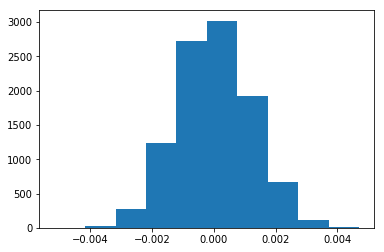

In [28]:
# plot histogram of differences
plt.hist(p_diffs);

__Answer__

The histogram displays the bootstrapped sample distribution for difference in conversion rates betweeen treatment group and control group. The plot looks reasonable given the observed value of $p_{new}$ - $p_{old}$, for our simulated values from part (e) and (f).



j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

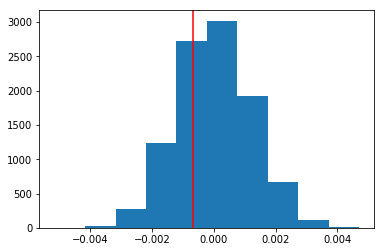

In [29]:
# plot the obs_diff calculated above 

plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='red');

In [30]:
# calculated proportion greater than observed difference (p-value)
(p_diffs > obs_diff).mean()

0.71840000000000004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**

The histogram plots the simulated sample distribution for difference in conversion rates betweeen treatment group and control group under the null hypothesis that $p_{new}$ and $p_{old}$ are equal.

The proportion of p_diffs that are greater than the actual difference observed un ab_data.csv is called the p-value. The p-value is calculated by bootstrapping the sample under the null to simulate the distribution of difference in proportions, then finding the probability that our statistic came from this distribution. The p-value is interpreted as all the null values that are more extreme than our statistic in favor of our alternative, and are the values of the histogram to the right of the obs_diff line.

With a standard cutoff level for significance of alpha = 0.05, if the p-value is less than 0.05, we reject the null hypothesis that there's no difference between the conversion rates and conclude that a significant difference does exist. If the p-value is larger than 0.05, we cannot conclude that a significant difference exists. 

Our __p-value of 0.625__ is much greater than 0.05 and so we fail to reject the null hypothesis. This suggests that the new page is no better than the old page and is not worth implementing.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
# calculate number of conversions for each page (group)
convert_old = df2.query('group == "control" and converted == 1').user_id.nunique();
convert_new = df2.query('group == "treatment" and converted == 1').user_id.nunique();
convert_old, convert_new

(17489, 17264)

In [32]:
import statsmodels.api as sm

# the following variables are calculated above
convert_old = convert_old
convert_new = convert_new
n_old = n_old
n_new = n_new


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm

count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])

z_score, p_value = proportions_ztest(count, nobs, alternative='larger')

print('z_score critical value to reject the null: ' + str(norm.ppf(1-(0.05/2))))
print('The z_score is: {0:0.4f}'.format(z_score))
print('The p_value is: {0:0.4f}'.format(p_value))


z_score critical value to reject the null: 1.95996398454
The z_score is: -1.3109
The p_value is: 0.9051


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**

The z_score is the regression coefficient divided by its standard error and represents the number of standard deviations a given statistic falls from the mean.

The observed conversion rate is 1.31 standard deviations below the mean, and within two standard deviations, which corresponds to the cut-off significance level of alpha = 0.05. Values within 2 standard deviations of the mean are not considered unusual. The z_score falls within the range of the critical value, so we fail to reject the null hypothesis that there is no difference between conversion rates for the new and old pages.

The p_value of 0.905 is very large, which also means we fail to reject the null hypothesis.

Both results are consistent with previous findings.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**  

With each row either a conversion or no conversion, this is a binary classification problem. __Logistic regression__ is appropriate in this case.


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# create intercept
df2['intercept'] = 1

In [35]:
# create dummies for treatment and control
df2[['ab_page', 'ab_page2']] = pd.get_dummies(df2.landing_page)
df2 = df2.drop('ab_page2', axis=1);
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
# import, instantiate, fit model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
# print summary results from Logistic Regression
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 28 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        04:27:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer**

The logit regression model returns a p-value associated with ab_page of 0.190. The p-value calculated manually was 0.625 and the p-value returned by the z-test builtin was 0.905.  

The difference in p-values may results from different null hypotheses statement of each test.

The null hypothesis in part II A/B Test assumes that there is no difference in probability of conversion between the old page and new page: that $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page. The alternative hypothesis is the difference is strictly positive, which is a one-sided test.

The null hypothesis in part III logistic regression is that there is no relationship between the X and y variables, the conversion rates between what page a user views and her probability of conversion. The alternative hypothesis is that there is some relationship between the variables, in either direction, which is a two-sided test.



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**

A/B tests make only one change at a time and does not take the interactions of independent variables into account. Adding additional factors to a logistic regression model can increase the explanatory power of the test. Additional explanatory variables in the dataset include date and time information, which may affect user decision making.

In the case of multiple logistic regression, if all variables are completely uncorrelated with each other, then the interpretation of coefficients is the same as in the univariate case. The coefficient $beta1$ is such that $ebeta1$ is the odds ratio for a unit change in X.

However, multivariate testing increases complexity of interpretation because of the risk that independent variables are correlated in some way. This collinearity can lead to skewed results when interpreting the effect of individual independent variables. The odds ratio for each variable must be adjusted for the effects of other variables. Confounding and collinearity can change and obscure these estimated relationships.



g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [38]:
# load country data
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')


In [39]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [40]:
# get unique country values
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [41]:
# create country dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [42]:
# instantiate and fit new logit model
logit_mod_country = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK']])
results_country = logit_mod_country.fit()
results_country.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 28 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        04:27:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [43]:
# interpret logit regression coefficients by exponentiation

# ab_page
print('ab_page: {}'.format(1/np.exp(-0.0149)))

# US
print('US: {}'.format(np.exp(0.0408)))

# UK
print('UK: {}'.format(np.exp(0.0506)))


ab_page: 1.0150115583846535
US: 1.0416437559600236
UK: 1.0519020483004984


__Does it appear that country had an impact on conversion?__

* For every unit less of the ab_page, the chance of conversion is 1.05 times more likely, holding other variables constant.
* For every unit more of UK, the chance of conversion is 1.04 times more likely, holding other variables constant.
* For every unit more of US, the chance of conversion is 1.05 times more likely, holding other variables constant. 



h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
# create interaction term for page and country
df_new['UK_new_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_new_page'] = df_new['US'] * df_new['ab_page']
df_new['CA_new_page'] = df_new['CA'] * df_new['ab_page']


In [45]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,UK_new_page,US_new_page,CA_new_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,0


In [46]:
# instantiate and fit Model; Obtain Results
logit_mod_interaction = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK', 'UK_new_page', 'US_new_page']])
results_country_int = logit_mod_interaction.fit()
results_country_int.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Mar 2019   Pseudo R-squ.:               3.482e-05
Time:                        04:27:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page        -0.0674      0.052     -1.297      0.195      -0.169       0.034
US              0.0175      0.038      0.465      0.642      -0.056       0.091
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.872      0.383      -0.059       0.152
===============================================================================
"""

In [47]:
# exponentiate regression coefficients
np.exp(results_country_int.params)

intercept      0.134794
ab_page        0.934776
US             1.017682
UK             1.011854
UK_new_page    1.081428
US_new_page    1.048001
dtype: float64

__Interpretation__

The addition of interaction terms to the logistic regression results in p-values for all coefficients besides the intercept term to be not significant at the 0.05 level. The z_score for these coefficients are also within 2 standard deviations of the mean, which indicates these results are not significant.

This specification does not appear to be a good choice of model selection.

In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0